In [1]:
from mnist import load_mnist

In [2]:
train, validation, test = load_mnist()
train_images, train_labels = train
test_images, test_labels = test

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [3]:
import matplotlib.pyplot as plt

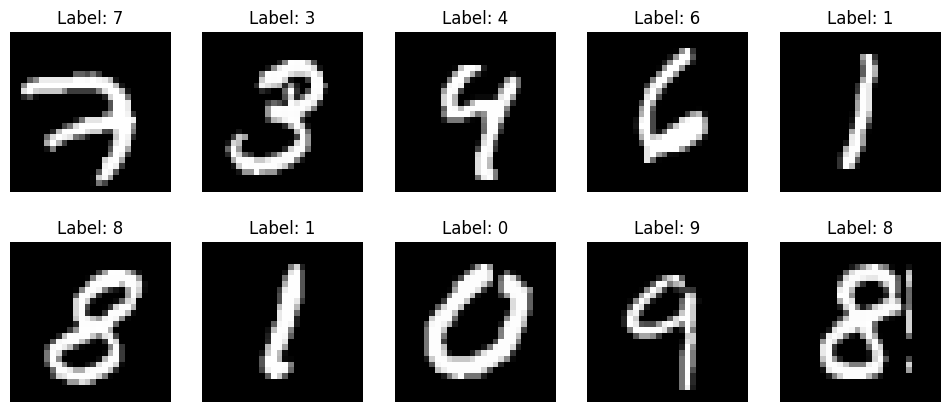

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {train_labels[i]}')
    ax.axis('off')
plt.show()

In [5]:
import numpy as np

class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components_ = None
        self.eigenvalues = None

    def fit(self, X):
        # Центрирование данных
        mean = np.mean(X, axis=0)
        X_centered = X - mean
        
        # Вычисление матрицы ковариации
        cov_matrix = np.cov(X_centered, rowvar=False)

        # Вычисление собственных векторов и собственных значений
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Упорядочивание собственных значений и векторов
        idx = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Выбор компонент
        if self.n_components is not None:
            self.components_ = eigenvectors[:, :self.n_components]
        else:
            self.components_ = eigenvectors

    def transform(self, X):
        return np.dot(X, self.components_)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [6]:
from sklearn.metrics import pairwise_distances

In [7]:
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        distances = pairwise_distances(X, self.X_train)
        indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        neighbors_labels = self.y_train[indices]
        predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=neighbors_labels)
        return predictions

In [8]:
pca = my_PCA(n_components=50)
num_samples, height, width, channels = train_images.shape
train_images_reshaped = train_images.reshape(num_samples, height * width * channels)
train_images_pca = pca.fit_transform(train_images_reshaped)

Text(0.5, 1.0, 'График собственных значений')

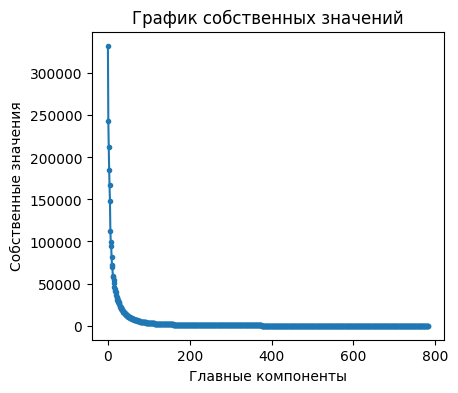

In [9]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(pca.eigenvalues, marker='.')
plt.xlabel('Главные компоненты')
plt.ylabel('Собственные значения')
plt.title('График собственных значений')

Text(0.5, 1.0, 'График кумулятивной суммы к полной сумме')

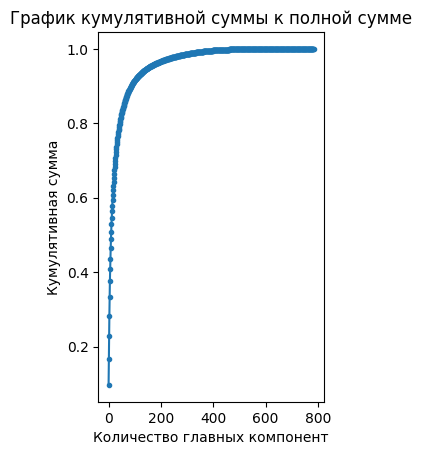

In [10]:
cumulative_sum = np.cumsum(pca.eigenvalues)/np.sum(pca.eigenvalues)

plt.subplot(1, 2, 2)
plt.plot(cumulative_sum, marker='.', linestyle='-')
plt.xlabel('Количество главных компонент')
plt.ylabel('Кумулятивная сумма')
plt.title('График кумулятивной суммы к полной сумме')

In [11]:
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

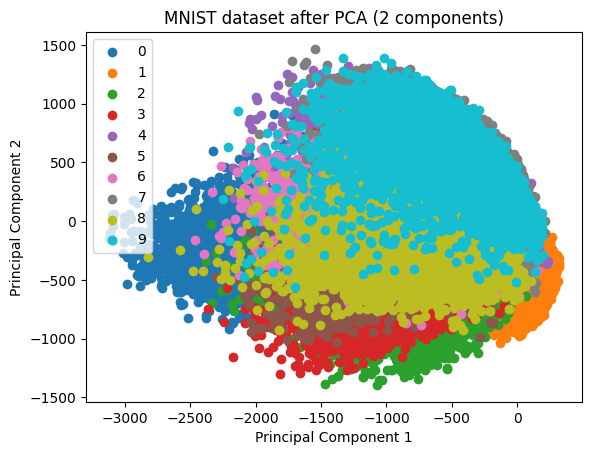

In [12]:
for i in range(10):
    plt.scatter(train_images_pca[train_labels == i, 0], train_images_pca[train_labels == i, 1], label=str(i))
plt.title('MNIST dataset after PCA (2 components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [14]:
X_train_pca, X_val_pca, y_train, y_val = train_test_split(train_images_pca, train_labels, test_size=0.1, random_state=42)

In [15]:
knn_classifier = my_kNN(n_neighbors=10)
knn_classifier.fit(train_images_pca, train_labels)

In [16]:
num_samples_test, height_test, width_test, channels_test = test_images.shape
test_images_reshaped = test_images.reshape(num_samples_test, height_test * width_test * channels_test)

In [17]:
test_images_pca = pca.transform(test_images_reshaped)

In [18]:
y_test_pred = knn_classifier.predict(test_images_pca)

In [19]:
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f'Accuracy of kNN classifier on test data after PCA: {test_accuracy:.2f}')

Accuracy of kNN classifier on test data after PCA: 0.97


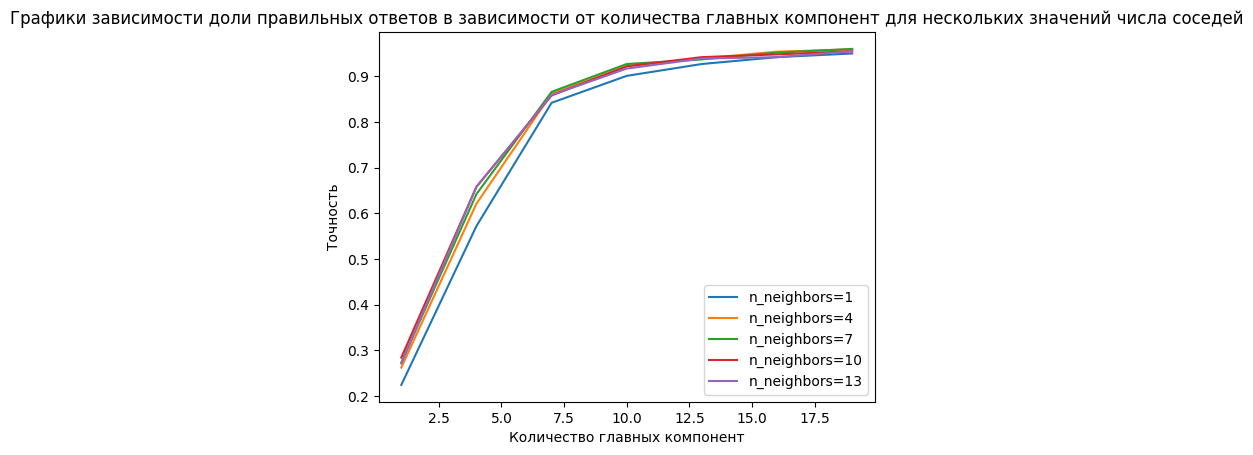

Наилучшая точность: 0.96
Наилучшее количество соседей: 7
Наилучшее количество компонент: 19


In [20]:
best_accuracy = 0
best_n_neighbors = 0
best_n_components = 0
pca = my_PCA(n_components=20)
X_tr_pca = pca.fit_transform(train_images_pca)
X_test_pca = pca.transform(test_images_pca)
accuracies = []

for n_neighbors in range(1, 15, 3):
    n_accuracies = []
    for n_components in range(1, 20, 3): # так как мой ноутбук другие значения делает примерно 1000 лет, я решила уменьшить количество компонентов
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_tr_pca[:, :n_components], train_labels)
        y_pred = knn.predict(X_test_pca[:, :n_components])
        accuracy = accuracy_score(test_labels[:1000], y_pred[:1000])
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = n_neighbors
            best_n_components = n_components
        n_accuracies.append(accuracy)
    accuracies.append(n_accuracies)
    plt.plot(range(1, 20, 3), n_accuracies, label=f'n_neighbors={n_neighbors}')

plt.xlabel('Количество главных компонент')
plt.ylabel('Точность')
plt.title('Графики зависимости доли правильных ответов в зависимости от количества главных компонент для нескольких значений числа соседей')
plt.legend()
plt.show()
print('Наилучшая точность:', best_accuracy) 
print('Наилучшее количество соседей:', best_n_neighbors) 
print('Наилучшее количество компонент:', best_n_components)


Вывод:
При выборе метода снижения размерности и классификации следует учитывать характеристики данных и целевые метрики качества.
Эксперименты с различными значениями параметров методов могут помочь найти оптимальную комбинацию для конкретной задачи.
В целом, для успешного решения задачи классификации рукописных цифр из базы данных MNIST важно подбирать оптимальные параметры методов, а также проводить анализ и интерпретацию результатов экспериментов.